In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from utils import *

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
target = 'category'
fake_data_name = 'PTI'
retrain = False

### 1. Prepare Data

In [4]:
train_real, test_real = prepare_data(target, 'real_images_embeddings')
train_fake, test_fake = prepare_data(target, fake_data_name)

# Combine real and fake data
train = ConcatDataset([train_real, train_fake])
test = ConcatDataset([test_real, test_fake])

print(f"Target: {train_real.target}")
print(f"\tNumber of classes: {len(train_real.id2label)}")

print(f"\tNumber of training samples: {len(train)}")
print(f"\tNumber of testing samples: {len(test)}")

Target: category
	Number of classes: 8
	Number of training samples: 11658
	Number of testing samples: 2902


### 2. Training

In [5]:
## Model Parameters
embeddings_shape = train_real[0][0].shape[0]
num_classes = len(train_real.id2label)

## Training Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
LR = 5e-4
loss_fn = nn.CrossEntropyLoss()

## Initialize Model and Optimizer
device = set_device()
model = ClassifierModel(embeddings_shape, num_classes)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

model_save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{target}_{fake_data_name}.pt"

Using cpu as device


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Initial Train Accuracy: 0.05395436610053182, Initial Test Accuracy: 0.05410062026188835
Epoch 1/30, Loss: 0.9372127652168274, Train Accuracy: 0.6397323726196603, Test Accuracy: 0.6288766368022054
Epoch 2/30, Loss: 0.8509575128555298, Train Accuracy: 0.6855378281008749, Test Accuracy: 0.6640248104755341
Epoch 3/30, Loss: 0.973133385181427, Train Accuracy: 0.6981471950591869, Test Accuracy: 0.6681598897312199
Epoch 4/30, Loss: 0.8716480135917664, Train Accuracy: 0.722336592897581, Test Accuracy: 0.6853893866299104
Epoch 5/30, Loss: 1.555541753768921, Train Accuracy: 0.7214788128323898, Test Accuracy: 0.669882839421089
Epoch 6/30, Loss: 0.5689101219177246, Train Accuracy: 0.7442099845599588, Test Accuracy: 0.6829772570640937
Epoch 7/30, Loss: 0.8267127871513367, Train Accuracy: 0.7555326814204838, Test Accuracy: 0.6888352860096485
Epoch 8/30, Loss: 1.185538649559021, Train Accuracy: 0.7673700463201235, Test Accuracy: 0.6895244658855961
Epoch 9/30, Loss: 0.7328196167945862, Train Accuracy:

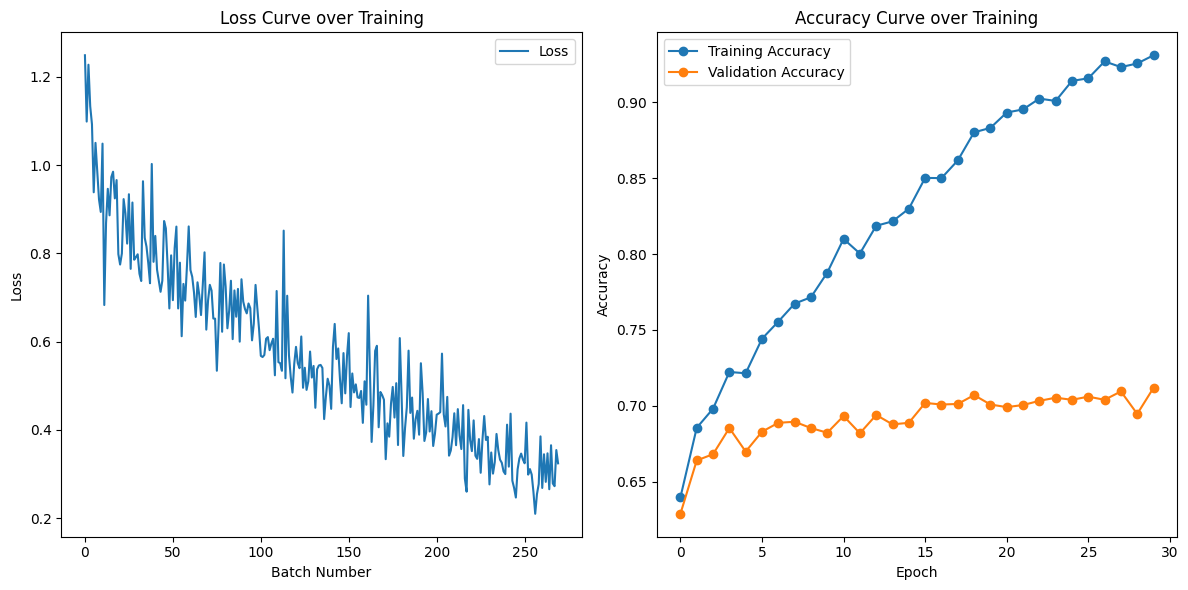

In [6]:
# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
if retrain or not os.path.exists(model_save_path):
    train_model(model, NUM_EPOCHS, optimizer, loss_fn, train_loader, test_loader, model_save_path, device, log_every=10)
else:
    model = torch.load(model_save_path, map_location = 'cpu')

### 3. Evaluation

In [7]:
print("Overall Accuracy:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test), device)}")

print("Accuracy on real data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_real), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_real), device)}")

print("Accuracy on fake data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_fake), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_fake), device)}")

Overall Accuracy:
	Training Set: 0.9310344827586207
	Testing Set: 0.7119228118538938
Accuracy on real data:
	Training Set: 0.9297652916073968
	Testing Set: 0.7140825035561877
Accuracy on fake data:
	Training Set: 0.9658536585365853
	Testing Set: 0.6444444444444445


#### Top N Accuracy

In [8]:
real_loader = DataLoader(ConcatDataset([train_real, test_real]), batch_size=BATCH_SIZE, shuffle=False)
fake_loader = DataLoader(ConcatDataset([train_fake, test_fake]), batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def get_top_n_predictions(loader, n):
    predictions = {}

    for embeddings, labels, sku in loader:
        output = model(embeddings.to(device))
        prob, predicted = torch.topk(torch.softmax(output, 1), n)

        for i in range(len(predicted)):
            predictions[sku[i]] = [train_real.id2label[labels[i].item()]] + [train_real.id2label[predicted[i][j].item()] for j in range(n)] + [prob[i][j].item() for j in range(n)]

    df = pd.DataFrame(predictions).T.reset_index()
    df.columns = ['sku'] + ['target'] + [f'pred_{i}' for i in range(n)] + [f'prob_{i}' for i in range(n)]

    df['top1_correct'] = df['target'] == df['pred_0']
    for i in range(1, n):
        df[f'top{i+1}_correct'] = df[f'top{i}_correct'] | (df['target'] == df[f'pred_{i}'])
    return df


In [10]:
real_predictions = get_top_n_predictions(real_loader, 3)
fake_predictions = get_top_n_predictions(fake_loader, 3)

real_predictions['dataset'] = real_predictions.sku.apply(lambda x: 'train' if x in train_real.df.sku.to_list() else 'test')
fake_predictions['dataset'] = fake_predictions.sku.apply(lambda x: 'train' if x in train_fake.df.sku.to_list() else 'test')

In [11]:
print("Real Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {real_predictions[real_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

print("Reconstructed Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {fake_predictions[fake_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

Real Images:
	Train Set:
		Top 1: 0.9297652916073968
		Top 2: 0.9876422475106685
		Top 3: 0.9970661450924608
	Test Set:
		Top 1: 0.7140825035561877
		Top 2: 0.884068278805121
		Top 3: 0.9487908961593172
Reconstructed Images:
	Train Set:
		Top 1: 0.9658536585365853
		Top 2: 0.9975609756097561
		Top 3: 0.9975609756097561
	Test Set:
		Top 1: 0.6444444444444445
		Top 2: 0.8111111111111111
		Top 3: 0.9333333333333333


In [12]:
print('Real Images:')
display(real_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False))

print('Reconstructed Images:')
fake_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False)

Real Images:


target
Denim dress                     0.961538
Jumper dress                    0.956762
Occasion wear                   0.933905
Day dress                       0.924633
Maxi dress                      0.889341
Cocktail dress / Party dress    0.838618
Shift dress                     0.830357
Jersey dress                    0.729050
Name: top1_correct, dtype: float64

Reconstructed Images:


target
Occasion wear                   0.947368
Jumper dress                    0.937500
Day dress                       0.934066
Maxi dress                      0.933333
Cocktail dress / Party dress    0.916667
Denim dress                     0.857143
Shift dress                     0.857143
Jersey dress                    0.800000
Name: top1_correct, dtype: float64

In [13]:
pd.crosstab(real_predictions.target, real_predictions.pred_0)

pred_0,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
target,,,,,,,,
Cocktail dress / Party dress,1481,129,0,11,13,41,59,32
Day dress,43,4846,3,89,64,149,10,37
Denim dress,0,6,300,1,0,5,0,0
Jersey dress,14,267,0,1305,94,73,9,28
Jumper dress,8,30,0,20,1903,16,2,10
Maxi dress,4,110,0,11,12,1310,26,0
Occasion wear,6,8,0,3,2,34,763,1
Shift dress,15,27,0,27,41,3,1,558


### Check some misclassified examples

In [17]:
def display_missclassified_samples(miss, num_samples=5):
    sample = miss.sample(num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(5 * num_samples, 10))

    for i in range(num_samples):
        sku = sample.iloc[i].sku
        img_path = f"{DATA_PATH}/Generated_Images/PTI/{sku}.jpg"
        img = Image.open(img_path)
        ax[i].imshow(img)

        # Construct title string with predictions and their probabilities
        title_text = f"SKU: {sku}\nTarget: {sample.iloc[i].target}"
        for j in range(3):  # Assuming there are always three predictions to display
            pred_col = f'pred_{j}'
            prob_col = f'prob_{j}'
            title_text += f"\nPrediction {j + 1}: {sample.iloc[i][pred_col]} ({np.round(sample.iloc[i][prob_col], 2)})"

        ax[i].set_title(title_text)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


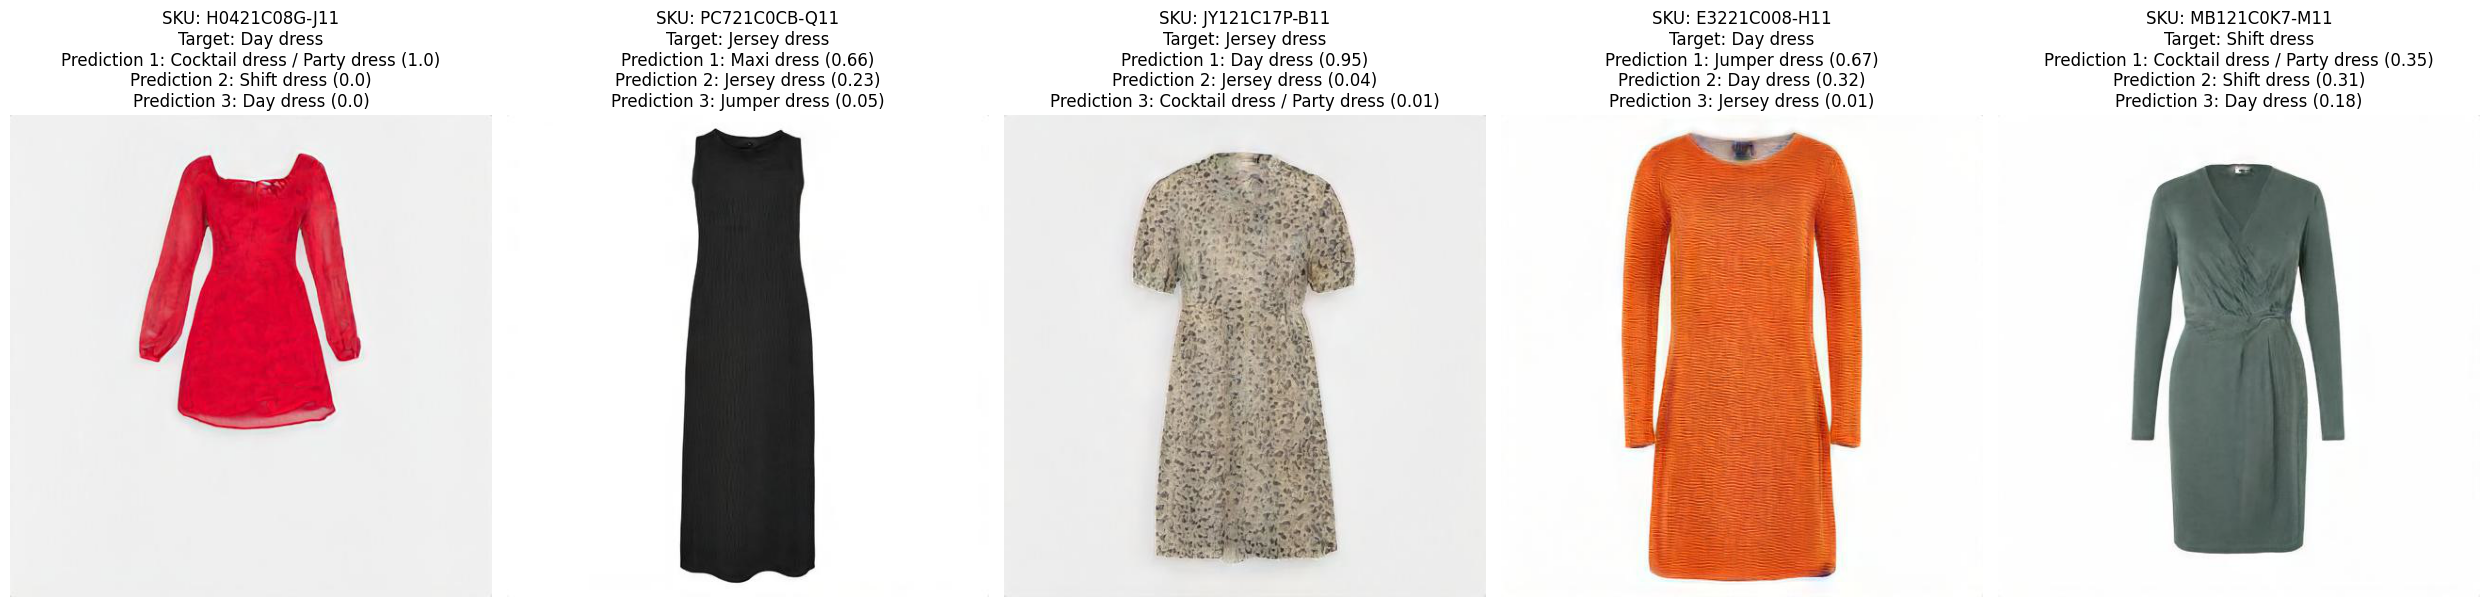

In [18]:
miss = fake_predictions[fake_predictions.target != fake_predictions.pred_0]
display_missclassified_samples(miss, 5)